Predction of IDHM of brazilian cities based on data about location, population age, amount basic sanitation companies, vehicles and so on.

#Load the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [3]:
#load data
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/Brazilian_Cities-incomp-RandomForest/BRAZIL_CITIES.csv',
               sep=';')

The dataframe looks like this:

In [4]:
df.head(1)

,CITY,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,IBGE_1,IBGE_1-4,IBGE_5-9,IBGE_10-14,IBGE_15-59,IBGE_60+,IBGE_PLANTED_AREA,IBGE_CROP_PRODUCTION_$,IDHM Ranking 2010,IDHM,IDHM_Renda,IDHM_Longevidade,IDHM_Educacao,LONG,LAT,ALT,PAY_TV,FIXED_PHONES,AREA,REGIAO_TUR,CATEGORIA_TUR,ESTIMATED_POP,RURAL_URBAN,GVA_AGROPEC,GVA_INDUSTRY,GVA_SERVICES,GVA_PUBLIC,GVA_TOTAL,TAXES,GDP,...,GDP_CAPITA,GVA_MAIN,MUN_EXPENDIT,COMP_TOT,COMP_A,COMP_B,COMP_C,COMP_D,COMP_E,COMP_F,COMP_G,COMP_H,COMP_I,COMP_J,COMP_K,COMP_L,COMP_M,COMP_N,COMP_O,COMP_P,COMP_Q,COMP_R,COMP_S,COMP_T,COMP_U,HOTELS,BEDS,Pr_Agencies,Pu_Agencies,Pr_Bank,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
0,Abadia De Goiás,GO,0,6876.0,6876.0,0.0,2137.0,1546.0,591.0,5300.0,69.0,318.0,438.0,517.0,3542.0,416.0,319.0,1843.0,1689.0,0.708,0.687,0.83,0.622,-49.440548,-16.758812,893.6,360.0,842.0,147.26,NaN,NaN,8583.0,Urbano,6.2,27991.25,74750.32,36915.04,145857.6,20554.2,166.41,...,20664.57,Demais serviços,28227691.0,284.0,5.0,1.0,56.0,0.0,2.0,29.0,110.0,26.0,4.0,5.0,0.0,2.0,10.0,12.0,4.0,6.0,6.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2158.0,1246.0,0.0,NaN,NaN,NaN,1.0


#####Pipe1

In [5]:
#defining columns with useless data to out model or to prevent data leakage
bad_columns = ['CATEGORIA_TUR','CITY', 'IDHM Ranking 2010', 'IDHM_Renda', 
               'IDHM_Longevidade', 'IDHM_Educacao', 'LONG', 'LAT', 'GVA_MAIN', 
               'REGIAO_TUR', 'MUN_EXPENDIT', 'HOTELS', 'BEDS', 'Pr_Agencies', 
               'Pu_Agencies', 'Pr_Bank', 'Pu_Bank', 'Pr_Assets', 'Pu_Assets',
               'UBER','MAC','WAL-MART']
               
#drop bad columns
def drop_bad_cols_cattur(df):
  df1=df.copy()
  df1.drop(bad_columns, 
          axis=1, 
          inplace=True)
  return df1

In [6]:
#drop columns where target is null
def drop_null_rows(df):
  return df.dropna(subset=['IDHM'])

In [7]:
#making the functions into transformers for the pipeline
get_drop_bad_cols_incial = FunctionTransformer(drop_bad_cols_cattur)
get_drop_row_null_target = FunctionTransformer(drop_null_rows)

#pipeline to remove bad columns and rows with missing target
pipe_inicial = make_pipeline(get_drop_bad_cols_incial, get_drop_row_null_target)

df_sem_cols_nan = pipe_inicial.fit_transform(df)

In [8]:
df_sem_cols_nan.head(2)

,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,IBGE_1,IBGE_1-4,IBGE_5-9,IBGE_10-14,IBGE_15-59,IBGE_60+,IBGE_PLANTED_AREA,IBGE_CROP_PRODUCTION_$,IDHM,ALT,PAY_TV,FIXED_PHONES,AREA,ESTIMATED_POP,RURAL_URBAN,GVA_AGROPEC,GVA_INDUSTRY,GVA_SERVICES,GVA_PUBLIC,GVA_TOTAL,TAXES,GDP,POP_GDP,GDP_CAPITA,COMP_TOT,COMP_A,COMP_B,COMP_C,COMP_D,COMP_E,COMP_F,COMP_G,COMP_H,COMP_I,COMP_J,COMP_K,COMP_L,COMP_M,COMP_N,COMP_O,COMP_P,COMP_Q,COMP_R,COMP_S,COMP_T,COMP_U,Cars,Motorcycles,Wheeled_tractor,POST_OFFICES
0,GO,0,6876.0,6876.0,0.0,2137.0,1546.0,591.0,5300.0,69.0,318.0,438.0,517.0,3542.0,416.0,319.0,1843.0,0.708,893.60,360.0,842.0,147.26,8583.0,Urbano,6.20,27991.25,74750.32,36915.04,145857.60,20554.2,166.41,8053.0,20664.57,284.0,5.0,1.0,56.0,0.0,2.0,29.0,110.0,26.0,4.0,5.0,0.0,2.0,10.0,12.0,4.0,6.0,6.0,1.0,5.0,0.0,0.0,2158.0,1246.0,0.0,1.0
1,MG,0,6704.0,6704.0,0.0,2328.0,1481.0,847.0,4154.0,38.0,207.0,260.0,351.0,2709.0,589.0,4479.0,18017.0,0.690,753.12,77.0,296.0,881.06,6972.0,Rural Adjacente,50524.57,25917.70,62689.23,28083.79,167215.28,12873.5,180.09,7037.0,25591.70,476.0,6.0,6.0,30.0,1.0,2.0,34.0,190.0,70.0,28.0,11.0,0.0,4.0,15.0,29.0,2.0,9.0,14.0,6.0,19.0,0.0,0.0,2227.0,1142.0,0.0,1.0


#Exploratory Data Analysis

In the file cols_explain there's a description of each column in the dataframe

In [ ]:
#load columns explanation
cols_explain=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/Brazilian_Cities-incomp-RandomForest/Data_Dictionary.csv',
               sep=';', 
               decimal=',')
#drop empty rows
cols_explain.dropna(axis=0, inplace=True, how='all')

cols_explain.head(3)

,FIELD,DESCRIPTION,REFERENCE,UNIT,SOURCE,Unnamed: 5
0,CITY,Name of the City,NaN,NaN,-,NaN
1,STATE,Name of the State,NaN,NaN,-,NaN
2,CAPITAL,1 if Capital of State,NaN,NaN,-,NaN


##Correlation

The correlation helps us to know the data better, which features are most important to predict the target.

In [ ]:
fclassif_drop_vars = ['STATE','RURAL_URBAN','AREA']
#score_func defines the function and k means it will return the k best (highest score) vars
df_fclassif = df_sem_cols_nan.drop(fclassif_drop_vars,axis=1).copy()
df_fclassif_nan = df_fclassif.dropna(axis=0,how='any')
y_fclassif = df_fclassif_nan.IDHM
x_fclassif = df_fclassif_nan.drop('IDHM',axis=1).copy()

algoritmo = SelectKBest(score_func=f_classif, k=10)
best_k_features = algoritmo.fit_transform(x_fclassif,y_fclassif)

scores_fclassif = pd.DataFrame(algoritmo.scores_,x_fclassif.columns)
#print results
print(scores_fclassif.sort_values(by=0, ascending=False).head(10))

                        0
COMP_E           9.255847
COMP_D           9.235137
Wheeled_tractor  9.231580
COMP_H           8.968747
GDP_CAPITA       8.430360
COMP_I           8.315375
COMP_G           8.281256
GVA_INDUSTRY     8.239485
PAY_TV           8.222975
Motorcycles      8.141012


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [49] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
fig = plt.figure(figsize=(70,33))
plt.bar(scores_fclassif.index,height=scores_fclassif[0])
plt.show()

COMP_E and COMP_D seems to be very important to the IDHM of a city. Checking in the `cols_explain`, we see that this columns are the amount of companies that provide Electricity and gas and the amount of companies that provide Water, sewage, waste management and decontamination activities. That makes sanse, this cities have better basic services, so it has a better IDHM.

The surprise is the 3rd place, `Wheeled_tractor` also appear to be a important indicator of IDHM.

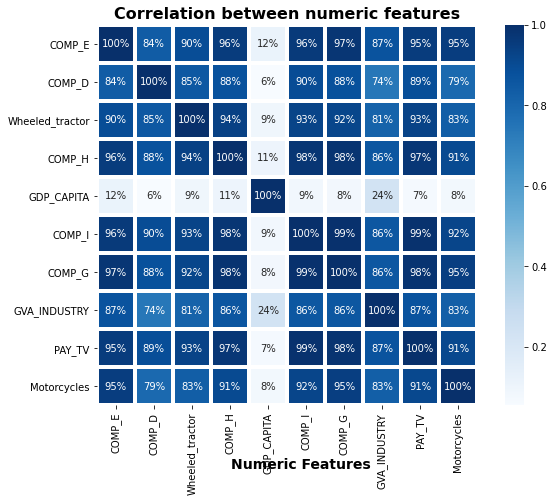

In [ ]:
columns_of_interest = ['COMP_E','COMP_D','Wheeled_tractor','COMP_H','GDP_CAPITA',
                       'COMP_I','COMP_G','GVA_INDUSTRY','PAY_TV','Motorcycles']

# Correlation between numeric variables
fig=plt.figure(figsize=(10,7))
axis=sns.heatmap(x_fclassif[columns_of_interest].corr(), annot=True, linewidths=3, square=True, cmap='Blues', fmt=".0%",)

#styling the plot
axis.set_title('Correlation between numeric features', fontsize=16, weight='bold', y=1.05);
#axis.set_xticklabels(num_var, fontsize=12)
#axis.set_yticklabels(num_var, fontsize=12, rotation=0);

fig.text(0.5, 0.0, 'Numeric Features', ha = 'center', fontsize = 14, weight = 'bold');

##Columns types

Let's find out which columns are dtype object 

In [9]:
object_columns = df_sem_cols_nan.select_dtypes(object).columns
object_columns

Index(['STATE', 'AREA', 'RURAL_URBAN'], dtype='object')

`STATE`, `CATEGORIA_TUR`, `RURAL_URBAN` are actual categorical variables, we're going to One hot econde it.

The `AREA` is a numerical feature but it has commas separating the thousands. We're going to remove the commas and transform the columns in numerical.

In [10]:
numeric_vars = df_sem_cols_nan.columns.drop(['STATE','RURAL_URBAN','IDHM'],errors='ignore').to_list()
categorical_vars = ['STATE','RURAL_URBAN'] 

#declaring selectors to use in column transformers
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

##Outliers

#Spliting the data

In [11]:
df1 = pipe_inicial.fit_transform(df) #drop_null_rows(df_sem_cols_nan)
x = df1.drop('IDHM', axis=1).copy()
y = df1.IDHM
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=0)

In [12]:
x_train.head(1)

,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,IBGE_1,IBGE_1-4,IBGE_5-9,IBGE_10-14,IBGE_15-59,IBGE_60+,IBGE_PLANTED_AREA,IBGE_CROP_PRODUCTION_$,ALT,PAY_TV,FIXED_PHONES,AREA,ESTIMATED_POP,RURAL_URBAN,GVA_AGROPEC,GVA_INDUSTRY,GVA_SERVICES,GVA_PUBLIC,GVA_TOTAL,TAXES,GDP,POP_GDP,GDP_CAPITA,COMP_TOT,COMP_A,COMP_B,COMP_C,COMP_D,COMP_E,COMP_F,COMP_G,COMP_H,COMP_I,COMP_J,COMP_K,COMP_L,COMP_M,COMP_N,COMP_O,COMP_P,COMP_Q,COMP_R,COMP_S,COMP_T,COMP_U,Cars,Motorcycles,Wheeled_tractor,POST_OFFICES
3890,RN,0,13949.0,13949.0,0.0,3365.0,1804.0,1561.0,7399.0,110.0,450.0,696.0,757.0,4577.0,809.0,1153.0,5417.0,88.66,109.0,116.0,230.40,15294.0,Rural Adjacente,6283.53,3.83,17311.89,66527.8,93952.06,2517.95,96470.01,15280.0,6313.48,59.0,0.0,0.0,3.0,0.0,0.0,4.0,43.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,4.0,0.0,0.0,842.0,1462.0,0.0,1.0


#Baseline

Let's build a baseline to compare the modifications in the model. We're starting as simple as possible, dropping categorical columns and samples with missing values.

In [13]:
def drop_object_cols(df):
  """" drop object type columns"""
  return df.drop(object_columns,axis=1).copy()

get_drop_object_cols = FunctionTransformer(drop_object_cols)

Let's compare a few different regressors and choose the best performances.

In [ ]:
#make a pipeline to fill na with mean and apply randomforest regressor
pipe_base = Pipeline([
                      ('Drop_cat',get_drop_object_cols),
                      ('Fill_na',SimpleImputer(strategy='median')),
                      ('model',GradientBoostingRegressor())])

grid_base = {'model': [GradientBoostingRegressor(),
                       RandomForestRegressor(),
                       SVR(),
                       SGDRegressor(),
                       LinearRegression()]}

search_models = GridSearchCV(estimator=pipe_base,
                             param_grid=grid_base,
                             n_jobs=-1, 
                             cv=5)
search_models.fit(x_train,y_train)

In [15]:
print(search_models.best_estimator_,
      f'\nBest Score: {search_models.best_score_}')

Pipeline(memory=None,
         steps=[('Drop_cat',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function drop_object_cols at 0x7fbd36d064d0>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('Fill_na',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('model',
                 RandomFor...gressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impu

In [16]:

#cross validation in the train data so we don't have to partition it into train 
#and validation and reduce even more the train data
score_base = cross_val_score(pipe_base, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_base.mean(),4)} and standard deviation of {score_base.std()}')

accuracy of 0.8531 and standard deviation of 0.007021597296013236


That's our baseline model precision. 85.67% score in the cross validation.

In [17]:
pipe_base.fit(x_train,y_train)
pipe_base.score(x_test,y_test)

0.8575619964438362

A simple RandomForest Regressor filling the na with the mean got a accuracy of 86.14% in the test data

#Data Manipulation

## Fixing Columns dtype

Let's write a function to erase any commas that might appear in the data and change all numeric feature columns to numeric:

In [18]:
#Remove commas
def erase_commas(df):
  df1 = df.replace(',','', regex=True).copy()
  return df1

In [19]:
def change_to_numeric(df):
  # transforming object columns to numeric
  df[numeric_vars] = df[numeric_vars].apply(pd.to_numeric,errors='raise').copy()

  return df

##Missing Values

In [20]:
def faltantes_percentual(df):
  """we can see how much (%) of each column is missing """
  print((df.isnull().sum() / len(df.iloc[:,0])*100).sort_values(ascending=False))

In [21]:
faltantes_percentual(df_sem_cols_nan)

POST_OFFICES              2.120395
IBGE_DU_RURAL             1.329739
Cars                      0.143756
Wheeled_tractor           0.143756
Motorcycles               0.143756
IBGE_DU                   0.053908
IBGE_DU_URBAN             0.053908
AREA                      0.035939
IBGE_RES_POP              0.017969
IBGE_CROP_PRODUCTION_$    0.017969
 GVA_TOTAL                0.017969
GVA_PUBLIC                0.017969
GVA_SERVICES              0.017969
GVA_INDUSTRY              0.017969
GVA_AGROPEC               0.017969
RURAL_URBAN               0.017969
ALT                       0.017969
IBGE_60+                  0.017969
IBGE_PLANTED_AREA         0.017969
IBGE_RES_POP_BRAS         0.017969
IBGE_15-59                0.017969
GDP                       0.017969
IBGE_5-9                  0.017969
IBGE_1-4                  0.017969
IBGE_1                    0.017969
IBGE_POP                  0.017969
IBGE_RES_POP_ESTR         0.017969
IBGE_10-14                0.017969
TAXES               

Most of the features has less than 0.2% missing data. We can fill it with the median or the mean. `CATEGORIA_TUR` has 41% of missing data, so we can drop it or fill it with a regression.

We're going for the first because the second is too much trouble now, let's focus on finishing a pipeline fisrt. Than we're totally going for the second.

#Pipeline

Let's build a `Pipeline` for preprocessing the data

First, we need to call `FunctionTransformer` to make our functions into transformers so we can use them on the `Pipeline`.

In [22]:
get_erase_commas = FunctionTransformer(erase_commas, validate=False)
get_numeric_feat = FunctionTransformer(change_to_numeric, validate=False)

clean_data = Pipeline([
                  ('Erase Commas',get_erase_commas),
                  ('Change dtype to numeric', get_numeric_feat)])

In [23]:
#pipeline for columns transformations on categorical features
cat_preprocessing = make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='most_frequent'), 
                OneHotEncoder(handle_unknown='ignore'))

#column transformer to fill na in numeric columns with median
#and fill na in categorical cols with most frequent and apply OneHotEconder
ct_fillna_pipe1= ColumnTransformer(
     [("numeric transf", SimpleImputer(missing_values=np.nan, strategy='median'), num_selector),
      ("categorical transf", cat_preprocessing, cat_selector)])

In [24]:
pipe1 = Pipeline([
                  ('Data Cleaning', clean_data), 
                  ('Fill cat with most frequent and num with median and apply OneHotEncoder',ct_fillna_pipe1),
                  ('Apply Random Forest Model', RandomForestRegressor(random_state=0))])

In [25]:
score_pipe1 = cross_val_score(pipe1, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_pipe1.mean(),4)} and standard deviation of {score_pipe1.std()}')

accuracy of 0.8646 and standard deviation of 0.005653002115631265


Including the categorical features  `'STATE'` and `'RURAL_URBAN'` and the column `AREA` that was dtype object, and applying OneHotEncoder to them has increased our model accuracy from  85.67% (baseline) to 86.46%.

It's not much and it increases the computacional effort considerably. So let's drop'em.

It took almost 50 seconds to run the cross validation for RandomForest, it will be much longer for a gridsearch with multiple models. So let's normalize the num data with MinMaxScaler and apply PCA with 10 components. This should make the model computationally lighter. Let's check how much it impacts the performance.

In [27]:
#pipeline for columns transformations on numeric features
num_preprocessing = make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='median'), 
                StandardScaler(),
                PCA(n_components=10))

#column transformer to fill na in numeric columns with median
#and fill na in categorical cols with most frequent and apply OneHotEconder
ct_fillna_pipe2= ColumnTransformer(
     [("num", num_preprocessing, num_selector),
      ("cat", cat_preprocessing, cat_selector)])

In [28]:
pipe2 = Pipeline([
                  ('Preprocessing', clean_data), 
                  ('Fill cat with most frequent and num with median and apply OneHotEncoder',ct_fillna_pipe2),
                  ('Apply Random Forest Model', RandomForestRegressor(random_state=0))])

In [ ]:
score_pipe2 = cross_val_score(pipe2, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_pipe2.mean(),4)} and standard deviation of {score_pipe2.std()}')

The accuracy now is 81.03%, considerably lower than the baseline and it still took 50 seconds to execute. So let's drop PCA.

#The best model

#Hyperparameter tunning

In [29]:
#drop cat features
clean_data_hyper = Pipeline([
                  ('Erase Commas',get_erase_commas),
                  ('Change dtype to numeric', get_numeric_feat),
                  ('drop cat cols', get_drop_object_cols)
                  ])

In [51]:
pipe_hyper = Pipeline([
                  ('Preprocessing', clean_data_hyper),
                  ('Fill_NaN',SimpleImputer(strategy='mean')),
                  ('model_param',RandomForestRegressor())
                  ])

n_estimators_param = [50,100,200]
max_depth = [3,4,5,6]
min_samples_split = [2,3,4,5]
param_grid_RF = [{
              'model_param': [RandomForestRegressor()],
              'model_param__n_estimators': n_estimators_param,
              #'model_param__criterion': ['mse','mae'],
              'model_param__max_depth' : max_depth,
              'model_param__bootstrap' : [False, True],
              'model_param__min_samples_split' : min_samples_split,
              'Fill_NaN__strategy': ['median', 'mean']
           }]
param_grid_GB =[{  
              'model_param': [GradientBoostingRegressor()],
              'model_param__loss': ['ls','lad', 'huber', 'quantile'],
              'model_param__learning_rate': [0.01,0.1,0.5,1,10],
              'model_param__criterion' : ['friedman_mse', 'mse', 'mae'],
              'model_param__min_samples_split' : min_samples_split,
              'Fill_NaN__strategy': ['median', 'mean']    
           }]

In [ ]:
grid_RF = GridSearchCV(pipe_hyper, param_grid=param_grid_RF, cv=5)
grid.fit(x_train, y_train)

In [40]:
print(grid.best_estimator_,
      f'\nBest Score: {grid.best_score_}',
      f'\nBest Params: {grid.best_params_}')

In [ ]:
print(score_hyper.best_estimator_,
      f'\nBest Score: {score_hyper.best_score_}', score_hyper.best_params_)


In [45]:
score_hyper.mean()

0.856616057371047

In [ ]:
import pprint as pp

pp.pprint(sorted(pipe_hyper.get_params().keys()))

#Model ensemble


In [ ]:
#reference for implementing voting
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
     voting='soft')
params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)